<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png"
         width="500" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>
            Chair of Soil Mechanics and Foundation Engineering<br>
            Geotechnical Institute<br>
            Technische Universität Bergakademie Freiberg.
        </p>
        <p>
            <a href="https://tu-freiberg.de/en/soilmechanics">
                https://tu-freiberg.de/en/soilmechanics
            </a>
        </p>
    </div>
</div>

<div style="display: flex; align-items: center;">
    <p style="margin-top: 1em;">
        To activate the <strong>interactive features</strong> when in nbviewer mode, click on &quot;Execute on Binder&quot;
        <img src="https://mybinder.org/static/favicon.ico"
             alt="Binder"
             style="height: 1.1em; vertical-align: middle; margin: 0 6px;">
        on the top right. Then, click on Run → Run All Cells.
    </p>
</div>


# Setzungen unter beliebigen Lastfiguren

Eine Möglichkeit der Berechnung von Setzungen unter beliebigen Lastfiguren ist die Superposition der Boussinesq'schen Lösung vieler Einzelkräfte
$$
\Delta \sigma_{zz} = \frac{3F_z}{2\pi R^2} \frac{z^3}{R^3},
$$
die sich zur Gesamtlastfigur aufsummieren. Grundlage dafür ist die Linearität des Modells, die Superposition / Konvolution [1] erlaubt. Um Singularitätsprobleme mit der Boussinesq'schen Lösung zu vermeiden, wird alternativ die Rechtecklösung verwendet:

$$
    \Delta \sigma_{zz}(x,y,z) = \frac{q_0}{2\pi} \sum \limits_{i=0}^3 (-1)^i \left\{ \left[ \frac{1}{(x+x_i)^2 + z^2} + \frac{1}{(y+y_i)^2 + z^2} \right] \frac{(x+x_i)(y+y_i) z}{R_i} + \arctan \left[ \frac{(x+x_i)(y+y_i)}{z R_i} \right] \right\} \quad \text{mit} \quad R_i = \sqrt{(x+x_i)^2 + (y+y_i)^2 + z^2}
$$

Dabei sind die $x_i$ und $y_i$ die Eckpunkte des Fundaments mit den Abmessungen $(a \times b)$ in $x$ und $y$:

\begin{align}
    x_i &= \{-a/2,\ -a/2,\ a/2,\ a/2\} \quad \text{für } i \in [0,3]
    \\
    y_i &= \{-b/2,\ b/2,\ b/2,\ -b/2\} \quad \text{für } i \in [0,3]
\end{align}

[1] Nagel, T., Gerasimov, T., Remes, J., & Kern, D. (2025). Neighborhood Watch in Mechanics: Nonlocal Models and Convolution. SIAM Review, 67(1), 176–193. https://doi.org/10.1137/22M1541721

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D  # nötig für 3D
from concurrent.futures import ProcessPoolExecutor

In [37]:
# Parameter der Lastfläche
drand = 50. #unbelasteter Bereich
a, b = 600.0, 400.0 #Grundfläche der Last (einhüllendes Rechteck, falls kein rechteckförmiger Grundriss)
nx, ny = int(51*a/b), 51 #Gitterauflösung
dx = (a+drand) / nx
dy = (b+drand) / ny
x_centers = np.linspace(dx/2 - drand, (a+drand) - dx/2, nx)
y_centers = np.linspace(dy/2 - drand, (b+drand) - dy/2, ny)
X, Y = np.meshgrid(x_centers, y_centers)

In [38]:
# Flächenlastfunktion
# Kann auch Schichteneinteilung enthalten
#def f(x, y):
#        return 100 * (x / a ) * (1 - y / b) * np.heaviside(x,1) * np.heaviside(y,1) * np.heaviside(a-x,1) * np.heaviside(b-y,1)

def f(x, y):
    # Innenbereich mit maximaler Last
    a1 = 0.4 * a  # 40% von a
    b1 = 0.4 * b  # 40% von b
    x0 = a / 2
    y0 = b / 2

    # Abstand vom Mittelpunkt
    dx = np.abs(x - x0)
    dy = np.abs(y - y0)

    # Maximal erlaubte Halbausdehnung
    dx_max = a / 2
    dy_max = b / 2

    dx1 = a1 / 2
    dy1 = b1 / 2

    # Normierte Abstände (0 im Kern, 1 am Rand)
    nx = np.clip((dx - dx1) / (dx_max - dx1), 0, 1)
    ny = np.clip((dy - dy1) / (dy_max - dy1), 0, 1)

    # Last nimmt linear ab mit Entfernung von Zentrum
    load = 800 * (1 - np.maximum(nx, ny))

    # Bereich außerhalb des Rechtecks auf 0 setzen
    load *= np.heaviside(x, 1) * np.heaviside(y, 1) * np.heaviside(a - x, 1) * np.heaviside(b - y, 1)

    return load


Q = f(X, Y)

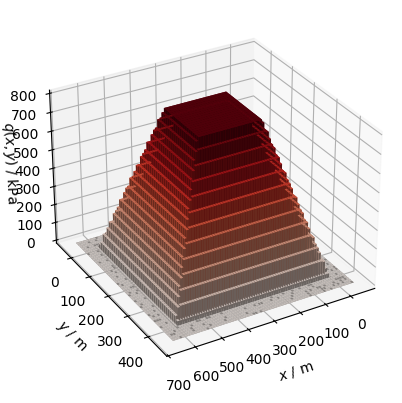

In [39]:
# Plot
from matplotlib.colors import Normalize
xpos = X.ravel()
ypos = Y.ravel()
Z = Q.ravel()
zpos = np.zeros_like(Z)  # bars start at z = 0

# Color mapping based on Z values
norm = Normalize(vmin=Z.min(), vmax=Z.max())
colors = plt.cm.Reds(norm(Z))

# Plot
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# 3D bar plot
ax.bar3d(xpos, ypos, zpos, dx, dy, Z, shade=True, color=colors)
ax.view_init(elev=30, azim=60)  # change view angle if needed

# Achsenbeschriftungcmap
ax.set_xlabel('$x$ / m')
ax.set_ylabel('$y$ / m')
ax.set_zlabel(r'$q(x,y)$ / kPa',labelpad=-2)
fig.tight_layout();
#fig.savefig('load_pyramid.pdf')

In [40]:
# Steifemodul als Funktion der Tiefe
def E_z(z):
    return 13000 + 4000 * np.sqrt(z)

In [41]:
def sigma_z_rectangle(x, y, z, s0, a, b, z_eps=1e-9):
    z = np.maximum(z, z_eps)

    # Ecken relativ zum Rechteckzentrum
    xi = np.array([-a/2, -a/2,  a/2,  a/2])[:, None, None]   # (4,1,1)
    yi = np.array([-b/2,  b/2,  b/2, -b/2])[:, None, None]   # (4,1,1)
    sign = np.array([1, -1, 1, -1])[:, None, None]           # (4,1,1)

    # x,y in 2D-Form bringen (ohne Kopie, falls schon 2D)
    X = np.asarray(x)[None, ...]  # (1,ny,nx) oder (1,...) broadcastbar
    Y = np.asarray(y)[None, ...]
    S0 = np.asarray(s0)[None, ...]

    Xc = X + xi
    Yc = Y + yi

    R = np.sqrt(Xc**2 + Yc**2 + z**2)

    term1 = (Xc * Yc * z / R) * (1.0/(Xc**2 + z**2) + 1.0/(Yc**2 + z**2))
    term2 = np.arctan2(Xc * Yc, R * z)

    sigma = (S0 / (2*np.pi)) * np.sum(sign * (term1 + term2), axis=0)
    return sigma

In [42]:
def compute_point_rect(ix, jy, z_layers, dz, x_centers, y_centers, Q, dx, dy):
    x_obs = x_centers[ix]
    y_obs = y_centers[jy]
    s_total = 0.0

    # Einmal pro Beobachtungspunkt: relative Koordinaten aller Zellzentren
    # Form: (ny, nx)
    Xc, Yc = np.meshgrid(x_centers, y_centers)   # default indexing='xy' -> passt zu Q[j,i]
    x_rel = x_obs - Xc
    y_rel = y_obs - Yc

    for z in z_layers:
        z_eff = z + dz/2

        # sigma_z-Beitrag aller Zellen in einem Rutsch
        sigma_grid = sigma_z_rectangle(x_rel, y_rel, z_eff, Q, dx, dy)

        # Gesamtspannung am Beobachtungspunkt
        delta_sigma = np.sum(sigma_grid)

        E = E_z(z_eff)
        s_total += (delta_sigma / E) * dz

    return jy, ix, s_total


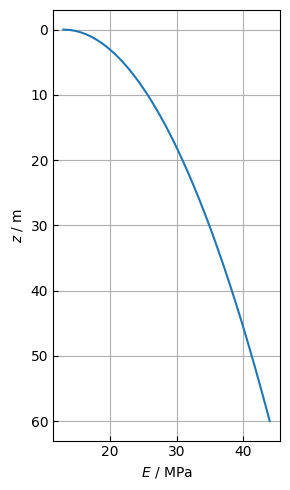

In [43]:
fig, ax = plt.subplots(figsize=(3,5))
z_layers = np.linspace(0, 60, 1000)
ax.plot(E_z(z_layers)/1e3,z_layers)
ax.invert_yaxis()
ax.grid(True)
ax.tick_params(direction='in')
ax.set_xlabel('$E$ / MPa')
ax.set_ylabel('$z$ / m')
fig.tight_layout();

In [44]:
# Wrapper zur parallelen Berechnung
def compute_settlement_parallel(z_max=10.0, nz=40):
    #z_min = 0.5*np.sqrt(dx**2 + dy**2) #nur bei Boussinesq zur Vermeidung der Singularität
    #print("Achtung: zmin von %.2f m verwendet." %z_min)
    z_min=0.
    z_layers = np.linspace(z_min, z_max, nz+1)[:-1]

    dz = z_layers[1] - z_layers[0]
    settlement = np.zeros((ny, nx))

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(compute_point_rect, ix, jy, z_layers, dz, x_centers, y_centers, Q, dx, dy)
                   for jy in range(ny) for ix in range(nx)]
        for future in futures:
            jy, ix, s_val = future.result()
            settlement[jy, ix] = s_val

    return settlement

In [45]:
settlement = compute_settlement_parallel(z_max=60.0,nz=20)

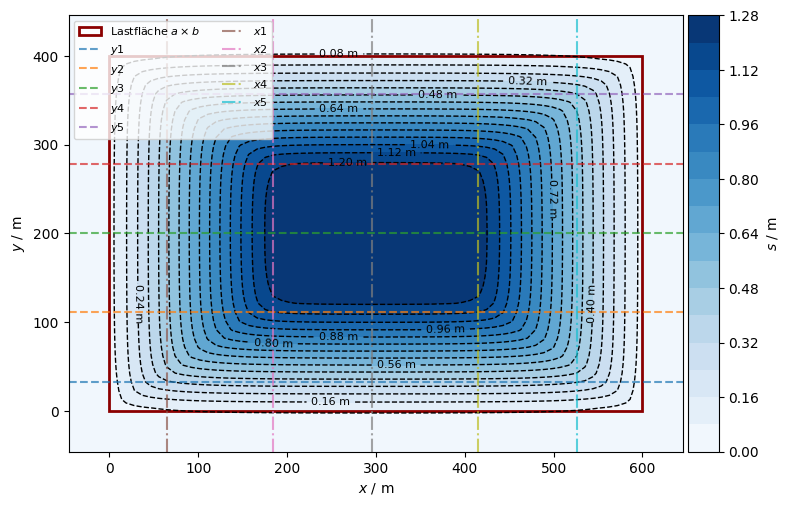

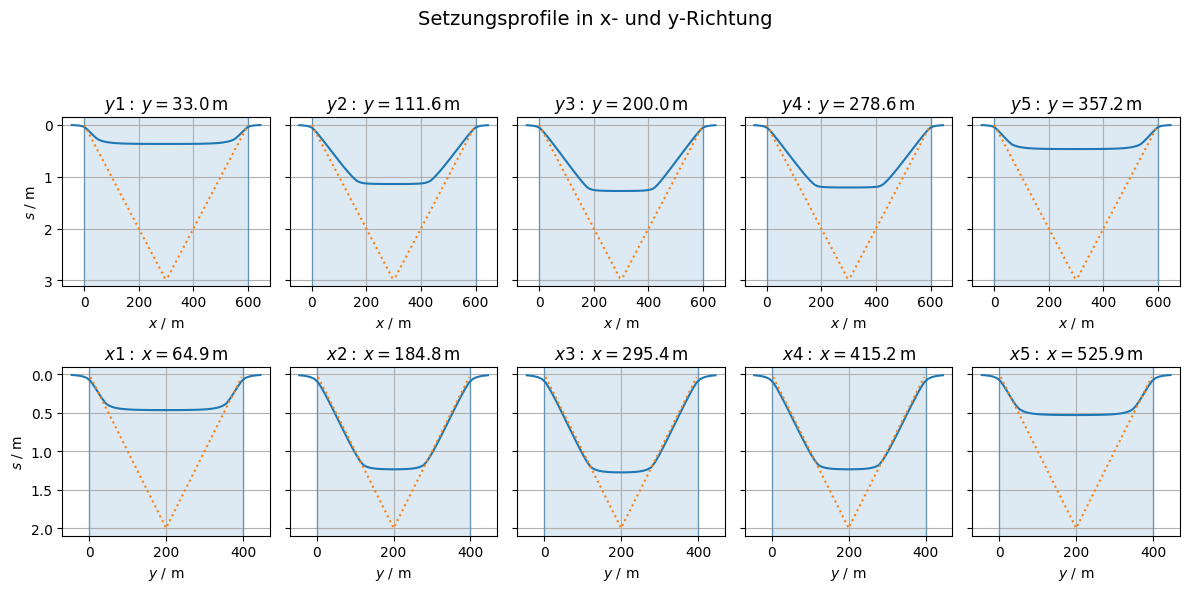

In [46]:
n_profiles = 7
ix_profiles = np.linspace(0, X.shape[1] - 1, n_profiles, dtype=int)
iy_profiles = np.linspace(0, Y.shape[0] - 1, n_profiles, dtype=int)

# nur mittlere Profile
ix_mid = ix_profiles[1:-1]
iy_mid = iy_profiles[1:-1]

# ============================================================
# Hilfsfunktion: 1% Neigung zur Mitte
# ============================================================
def slope_to_center_1pct_on_load(u, u0, u1):
    u = np.asarray(u)
    u_center = 0.5 * (u0 + u1)
    half_width = 0.5 * (u1 - u0)

    s_ref = np.full_like(u, np.nan, dtype=float)
    inside = (u >= u0) & (u <= u1)

    # "Dachlinie": 0 an den Rändern (u0/u1), Maximum in der Mitte
    s_ref[inside] = 0.01 * (half_width - np.abs(u[inside] - u_center))
    return s_ref

# =======================
# (A) 2D-Konturplot + Profile
# =======================
settlement_plot = settlement  # in m

fig, ax = plt.subplots(figsize=(8, 7))

c1 = ax.contourf(X, Y, settlement_plot, levels=20, cmap='Blues')
c2 = ax.contour(X, Y, settlement_plot, levels=20,
                colors='black', linewidths=1, linestyles='--')
ax.clabel(c2, inline=True, fontsize=8, fmt='%1.2f m')

# Lastfläche
rect = patches.Rectangle((0, 0), a, b,
                         linewidth=2, edgecolor='darkred',
                         facecolor='none', label=r'Lastfläche $a \times b$')
ax.add_patch(rect)

# y-Profile (horizontal) – nur mittlere
for k, iy in enumerate(iy_mid, start=1):
    ax.plot(X[iy, :], Y[iy, :],
            linestyle='--', linewidth=1.5, alpha=0.7,
            label=f'$y{k}$')

# x-Profile (vertikal) – nur mittlere
for k, ix in enumerate(ix_mid, start=1):
    ax.plot(X[:, ix], Y[:, ix],
            linestyle='-.', linewidth=1.5, alpha=0.7,
            label=f'$x{k}$')

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(c1, cax=cax, label='$s$ / m')

ax.set_xlabel('$x$ / m')
ax.set_ylabel('$y$ / m')
ax.set_aspect('equal')
ax.legend(loc='upper left', ncol=2, fontsize=8, frameon=True)
fig.tight_layout()

# =======================
# (B) Profile: 2 x 3 Subplots
# =======================
fig2, axes = plt.subplots(2, len(ix_mid), figsize=(12, 6), sharey='row')

# ---- obere Reihe: s(x) bei festem y
for k, iy in enumerate(iy_mid, start=1):
    axp = axes[0, k-1]
    x_line = X[iy, :]
    s_line = settlement[iy, :]

    axp.plot(x_line, s_line, label='Setzung')

    # Lastfläche als Band (x von 0 bis a)
    axp.axvspan(0, a, alpha=0.15, label='Lastfläche' if k == 1 else None)
    axp.axvline(0, linewidth=1, alpha=0.5)
    axp.axvline(a, linewidth=1, alpha=0.5)

    # 1% Neigung zur Mitte – NUR auf [0, a]
    s_ref = slope_to_center_1pct_on_load(x_line, 0.0, a)
    axp.plot(x_line, s_ref, linestyle=':', linewidth=1.5,
             label='1% Neigung → Mitte' if k == 1 else None)

    axp.set_title(f'$y{k}:\\; y = {Y[iy, 0]:.1f}\\,$m')
    axp.set_xlabel('$x$ / m')
    if k == 1:
        axp.set_ylabel('$s$ / m')
    axp.grid(True)
    axp.invert_yaxis()

# ---- untere Reihe: s(y) bei festem x
for k, ix in enumerate(ix_mid, start=1):
    axp = axes[1, k-1]
    y_line = Y[:, ix]
    s_line = settlement[:, ix]

    axp.plot(y_line, s_line, label='Setzung')

    # Lastfläche als Band (y von 0 bis b)
    axp.axvspan(0, b, alpha=0.15, label='Lastfläche' if k == 1 else None)
    axp.axvline(0, linewidth=1, alpha=0.5)
    axp.axvline(b, linewidth=1, alpha=0.5)

    # 1% Neigung zur Mitte – NUR auf [0, b]
    s_ref = slope_to_center_1pct_on_load(y_line, 0.0, b)
    axp.plot(y_line, s_ref, linestyle=':', linewidth=1.5,
             label='1% Neigung → Mitte' if k == 1 else None)

    axp.set_title(f'$x{k}:\\; x = {X[0, ix]:.1f}\\,$m')
    axp.set_xlabel('$y$ / m')
    if k == 1:
        axp.set_ylabel('$s$ / m')
    axp.grid(True)
    axp.invert_yaxis()

# Legend nur einmal – sammelt die "einmaligen" Labels
#handles, labels = axes[0, 0].get_legend_handles_labels()
#if handles:
#    fig2.legend(handles, labels, loc='lower center', ncol=3, frameon=True)

fig2.suptitle('Setzungsprofile in x- und y-Richtung', fontsize=14)
fig2.tight_layout(rect=[0, 0, 1, 0.92])

plt.show()
